**HOMEWORK**  

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```



In [2]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as MSE
%matplotlib inline

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
#@ DOWNLOADING THE DATASET: UNCOMMENT BELOW:
#!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [4]:
#@ READING DATASET:
PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

- Apply the log transform to `median_house_value`. 
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state parameter` to 1.

In [5]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:
df['median_house_value'] = np.log1p(df['median_house_value'])

from sklearn.model_selection import train_test_split
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

print(len(df_train), len(df_val), len(df_test))

12384 4128 4128


In [6]:
#df_train = df_train.reset_index(drop=True)
#df_val = df_val.reset_index(drop=True)
#df_test = df_test.reset_index(drop=True)

y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values
y_test = df_test['median_house_value'].values

print(y_train)

del df_train['median_house_value']
del df_val['median_house_value'] 
del df_test['median_house_value']



[12.33754379 10.91510665 12.06968575 ... 12.27373597 10.98700312
 12.18127265]


- We will use `DictVectorizer` to turn train and validation into matrices.

In [7]:

dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')

#@ IMPLEMENTATION OF DICTVECTORIZER:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_val = dv.fit_transform(dict_val)

**Question 1**

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1`.

In [8]:
#@ TRAINING THE REGRESSION MODEL:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [9]:
#@ INSPECTION:
from sklearn.tree import export_text 
tree_text = export_text(dt, feature_names=dv.feature_names_) 
print(tree_text)

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



- Which feature is used for splitting the data?

- Answer: ocean_proximity

**Question 2**

Train a random forest model with these parameters:

- `n_estimators=10`  
- `random_state=1`  
- `n_jobs=-1` (optional-to make training faster)

In [10]:
#@ TRAINING RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [11]:
#@ CALCULATING MEAN SQUARED ERROR:
y_pred_val = rf.predict(X_val)
print('Root Mean Squared Error = {0}'.format(round(np.sqrt(MSE(y_val, y_pred_val)),2)))

Root Mean Squared Error = 0.25


- What's the RMSE of this model on validation?

- Answer: 0.25

**Question 3**

Now, let's experiment with the `n_estimators` parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.

In [12]:
#@ TRAINING THE RANDOM FOREST MODEL:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)

    rf.fit(X_train, y_train)
    y_pred_val = rf.predict(X_val)
    
    rmse = round(np.sqrt(MSE(y_val, y_pred_val)),5)
    scores.append((n, rmse))

Like the people here said, -1 means all cores. It's better you put -1 than your real number, for example, 4 cores. If your code will be executed in another PC or platform the number of cores might be 6 and you can forget to change 4 to 6… 

In [13]:
#@ INSPECTING THE RMSE SCORES:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

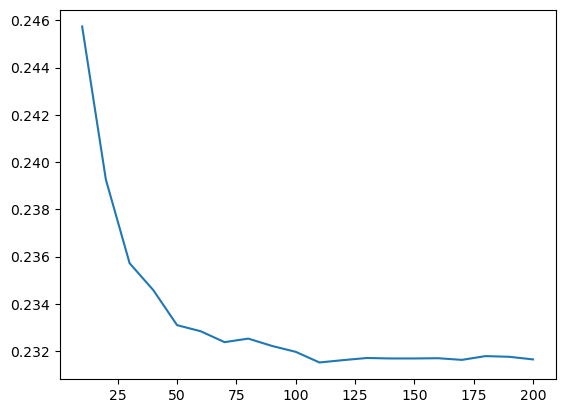

In [14]:
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.show()

- After which value of `n_estimators` does RMSE stop improving?

- Answer: 150...

**Question 4**

Let's select the best `max_depth`:

- Try different values of `max_depth`: [10, 15, 20, 25].
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
- Fix the random seed: `random_state=1`.

In [15]:
#@ TRAINING THE MODEL WITH DEPTH:
scores = []

for m in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(max_depth=m, n_estimators=n, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred_val = rf.predict(X_val)

        rmse = round(np.sqrt(MSE(y_val, y_pred_val)),5)
        scores.append((m , n, rmse))

In [16]:
df_scores_m_n = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'RMSE'])

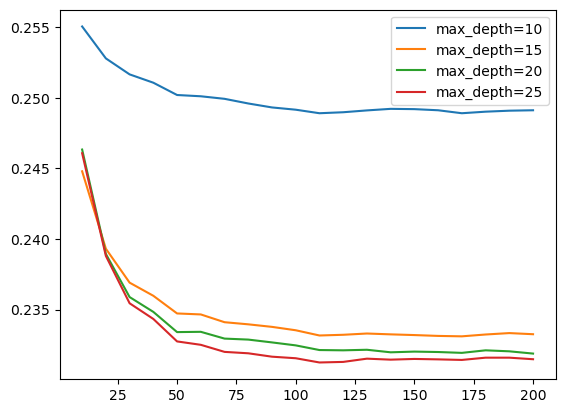

In [17]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores_m_n[df_scores_m_n.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset['RMSE'],
             label='max_depth=%d' % d)

plt.legend()

- What's the best `max_depth`:

- Answer: 25

**Question 5**

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- `n_estimators=10`,
- `max_depth=20`,
- `random_state=1`,
- `n_jobs=-1` (optional)

Get the feature importance information from this model

[1.69573183e-02 3.30938997e-02 1.01333971e-01 9.62649876e-02
 3.62912907e-01 3.00723750e-03 3.10900842e-01 3.56806263e-04
 4.48661972e-04 4.22762446e-03 3.09180197e-02 1.90412562e-02
 2.05364687e-02]


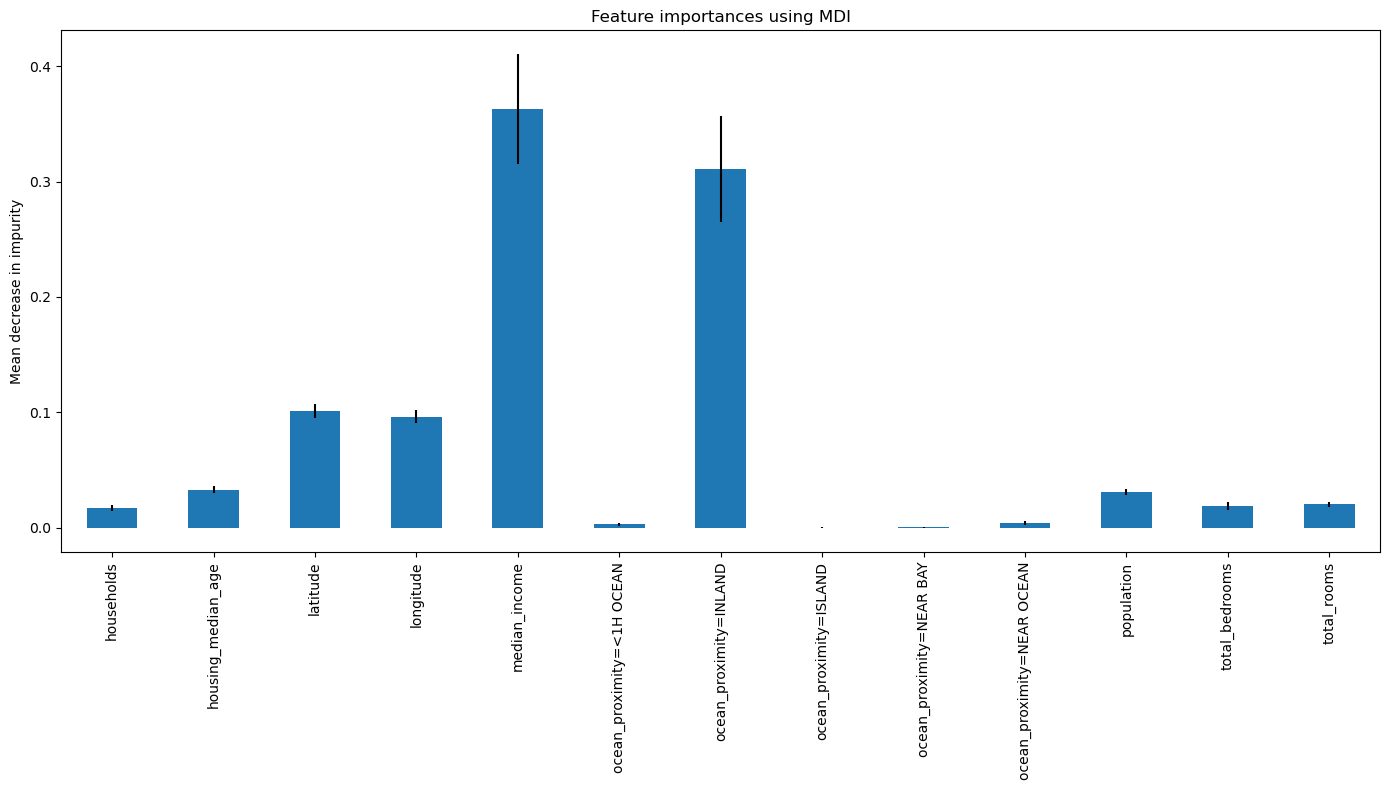

In [18]:
#@ TRAINING THE RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
print(importances)

importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=dv.feature_names_)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
fig, ax = plt.subplots(figsize = (14,8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

- What's the most important feature?

- Answer: median income 

**Question 6**

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```



In [74]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

print(features)

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

['households', 'housing_median_age', 'latitude', 'longitude', 'median_income', 'ocean_proximity=_1H OCEAN', 'ocean_proximity=INLAND', 'ocean_proximity=ISLAND', 'ocean_proximity=NEAR BAY', 'ocean_proximity=NEAR OCEAN', 'population', 'total_bedrooms', 'total_rooms']


In [68]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': -1,
    
    'seed': 1,
    'verbosity': 1,
}

In [69]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [83]:
%%capture output

model = xgb.train(xgb_params, dtrain,
                    num_boost_round=200,
                    evals=watchlist, verbose_eval=5)



In [84]:
s = output.stdout

print(s[:200])


[0]	train-rmse:8.12733	val-rmse:8.13245
[5]	train-rmse:1.40218	val-rmse:1.40741
[10]	train-rmse:0.34481	val-rmse:0.35782
[15]	train-rmse:0.23555	val-rmse:0.26044
[20]	train-rmse:0.21580	val-rmse:0.246


In [85]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [86]:
df_score = parse_xgb_output(output)

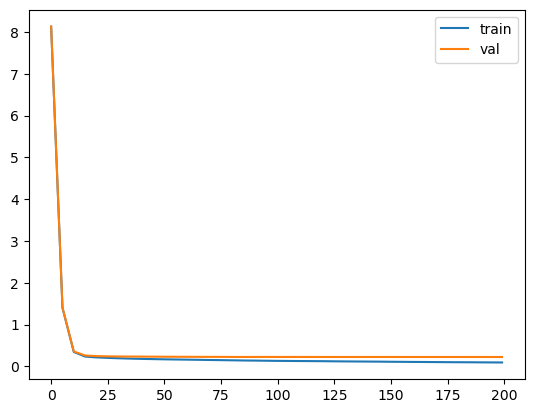

In [87]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

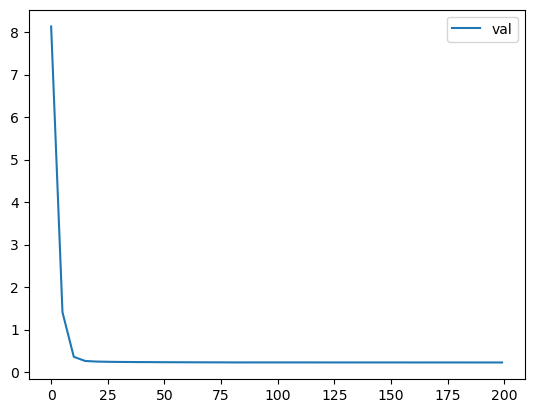

In [88]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [91]:
scores = {}

In [94]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': -1,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [95]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=6'

In [97]:
del scores['max_depth=6']

In [100]:
scores

{}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


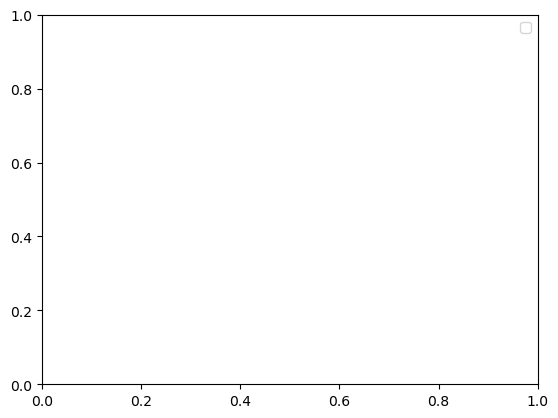

In [99]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)
plt.legend()

- Now, change eta first to 0.1 and then to 0.01.

- Which eta leads to the best RMSE score on the validation dataset?

- Answer: